In [544]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import os

## Loading metrics and truth set for training, evaluation and inference

The base directory of the folder containing the metrics files for the initital training and training is inserted into base_dir_metrics.
The base directory of the folder containing the metrics files for the inference step is inserted into base_dir_inference.
The truth CSV file is inserted into base_dir_truth.

In [545]:
base_dir_metrics = "results/metrics/all" 
base_dir_truth = "data/annotation/truth_set_all.csv" 
base_dir_inference = "results/metrics/inference_all" 

In [546]:
files = [
    "negative_review_count.csv",
    "negative_review_percentage.csv",
    "negative_sentiment_count.csv",
    "negative_sentiment_percentage.csv",
    "neutral_sentiment_count.csv",
    "neutral_sentiment_percentage.csv",
    "positive_review_count.csv",
    "positive_review_percentage.csv",
    "positive_sentiment_count.csv",
    "positive_sentiment_percentage.csv",
    "review_count.csv",
    "review_polarity.csv",
    "review_rating.csv",
    "review_word_count.csv"
]
feature_files = [os.path.join(base_dir_metrics, file) for file in files]

In [547]:
features = pd.DataFrame()
for file in feature_files:
    df = pd.read_csv(file)
    feature_name = file.split("/")[-1].split(".")[0]
    df.columns = ["App"] + list(df.columns[1:]) 
    df = df.melt(id_vars=["App"], var_name="Time window", value_name=feature_name)
    if features.empty:
        features = df
    else:
        features = pd.merge(features, df, on=["App", "Time window"], how="outer")

features["App"] = features["App"].astype(str)
features["Time window"] = features["Time window"].astype(str)

#unique identifier for merging
features["unique_id"] = features["App"] + "_" + features["Time window"]

truth_set = pd.read_csv(base_dir_truth)
truth_set["unique_id"] = truth_set["App"].astype(str) + "_" + truth_set["Time window"].astype(str)

#Merge
merged_data = pd.merge(features, truth_set, on="unique_id")

X = merged_data.drop(columns=["App_x", "unique_id", "Event", "Time window_x", "App_y", "Time window_y"])
y = merged_data["Event"].map({"yes": 1, "no": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [548]:
event = np.sum(y == 1)
non_event = np.sum(y == 0)
print("Received from the truth set:")
print(f"Number of predicted events: {event}")
print(f"Number of predicted non-events: {non_event}")
print("\nPredicting events. This may take a while...")

Received from the truth set:
Number of predicted events: 46
Number of predicted non-events: 26

Predicting events. This may take a while...


## Descriptive Feature Analysis

All plots displayed here are discussed in the thesis document.

### Summary statistics

In [549]:
summary_stats = features.describe()
summary_stats

,negative_review_count,negative_review_percentage,negative_sentiment_count,negative_sentiment_percentage,neutral_sentiment_count,neutral_sentiment_percentage,positive_review_count,positive_review_percentage,positive_sentiment_count,positive_sentiment_percentage,review_count,review_polarity,review_rating,review_word_count
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,157.537500,35.436562,59.725000,12.437523,128.612500,19.028799,325.637500,45.813438,294.837500,49.783678,483.175000,0.187016,2.742218,8.671156
std,381.939055,27.468945,145.179328,15.370323,347.033887,16.661586,893.709468,30.847564,770.765055,28.814001,1255.365939,0.150316,1.534594,7.638856
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.175000,0.000000,0.000000
25%,1.000000,15.835792,0.000000,0.000000,0.000000,0.000000,1.000000,19.326299,1.000000,40.379747,2.000000,0.054619,2.188559,5.327891
50%,13.000000,33.333333,3.000000,9.377289,10.000000,21.990330,26.500000,53.113553,26.500000,54.026644,46.500000,0.197976,3.305128,8.000000
75%,46.500000,50.000000,20.250000,16.964286,29.000000,28.571429,49.500000,70.043860,61.250000,66.840586,109.250000,0.291908,3.855300,11.513889
max,1939.000000,100.000000,668.000000,100.000000,1732.000000,66.666667,4200.000000,100.000000,3595.000000,100.000000,5597.000000,0.700000,5.000000,47.000000


### Bar plot of the mean and standard deviation of features

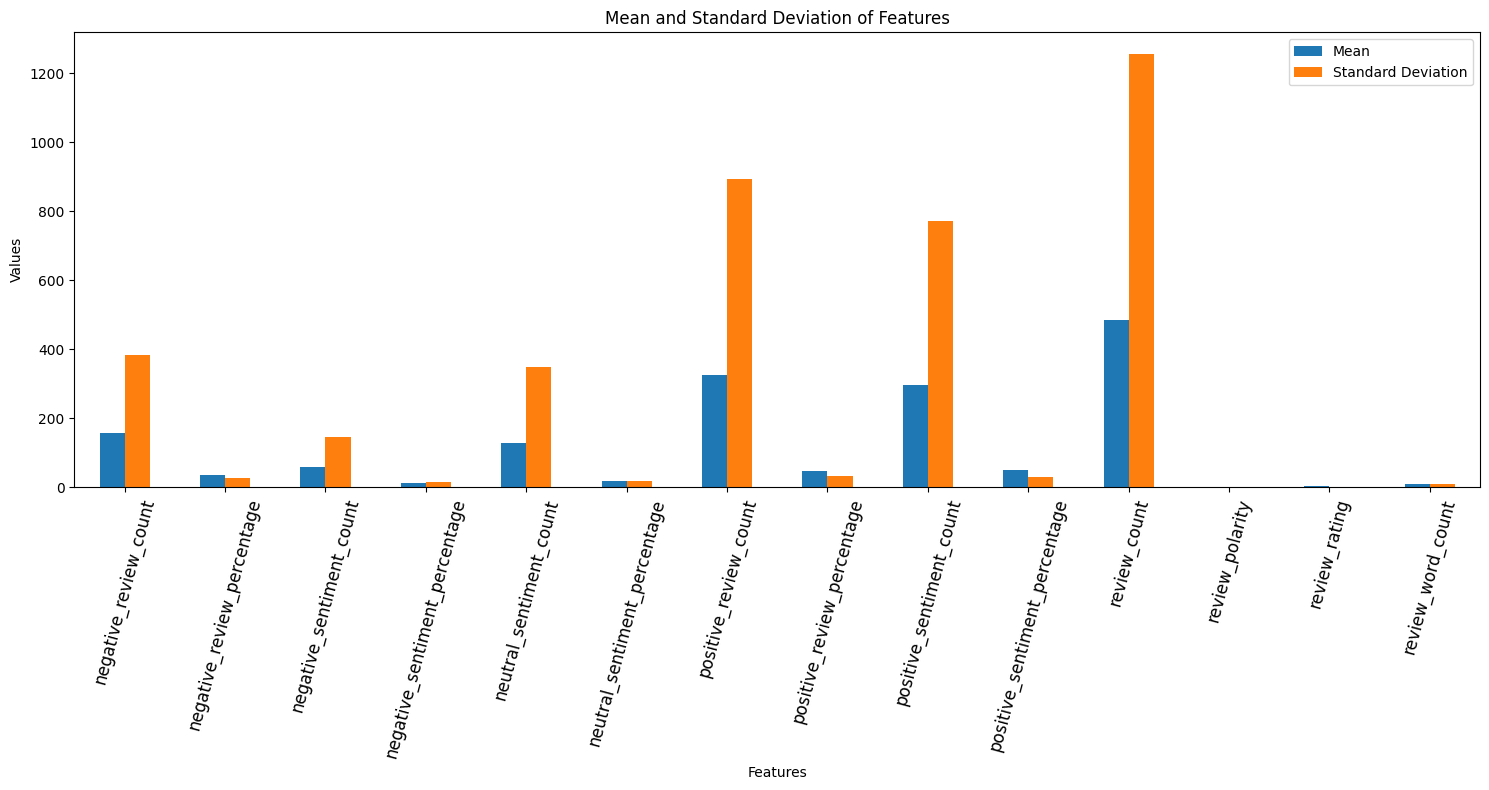

In [550]:
features_df = features.drop(columns=['App', 'Time window', 'unique_id']).apply(pd.to_numeric)

summary_stats = features_df.describe().T[['mean', 'std']]

fig, ax = plt.subplots(figsize=(15, 8))

summary_stats.plot(kind='bar', y=['mean', 'std'], ax=ax, capsize=4)
plt.title('Mean and Standard Deviation of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=75)
ax.tick_params(axis='x', labelsize=12)
plt.legend(['Mean', 'Standard Deviation'])
plt.tight_layout()
plt.show()


### Correlation heatmap

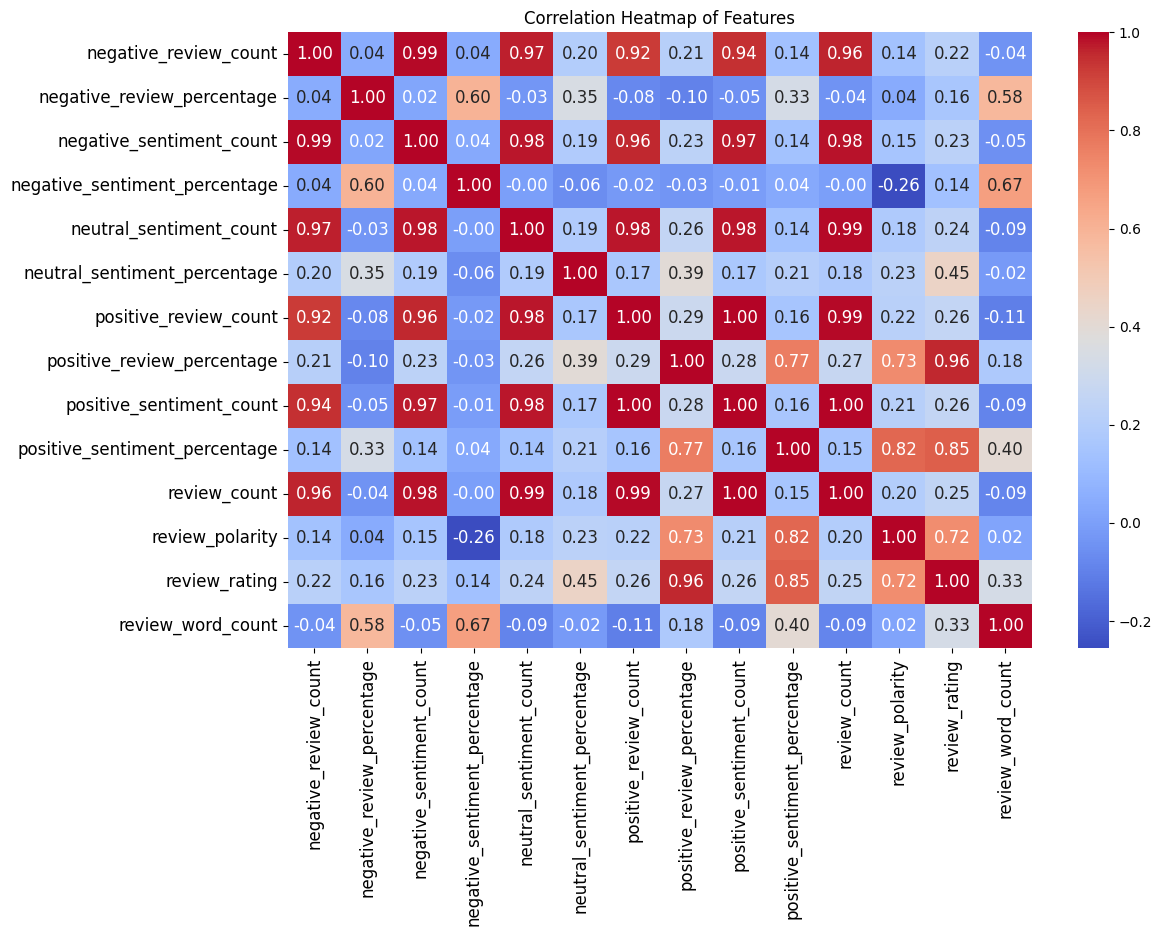

In [552]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(features_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 12})
heatmap.set_title('Correlation Heatmap of Features')  

heatmap.tick_params(axis='both', which='major', labelsize=12)
plt.show()


### Histogram distribution of each feature

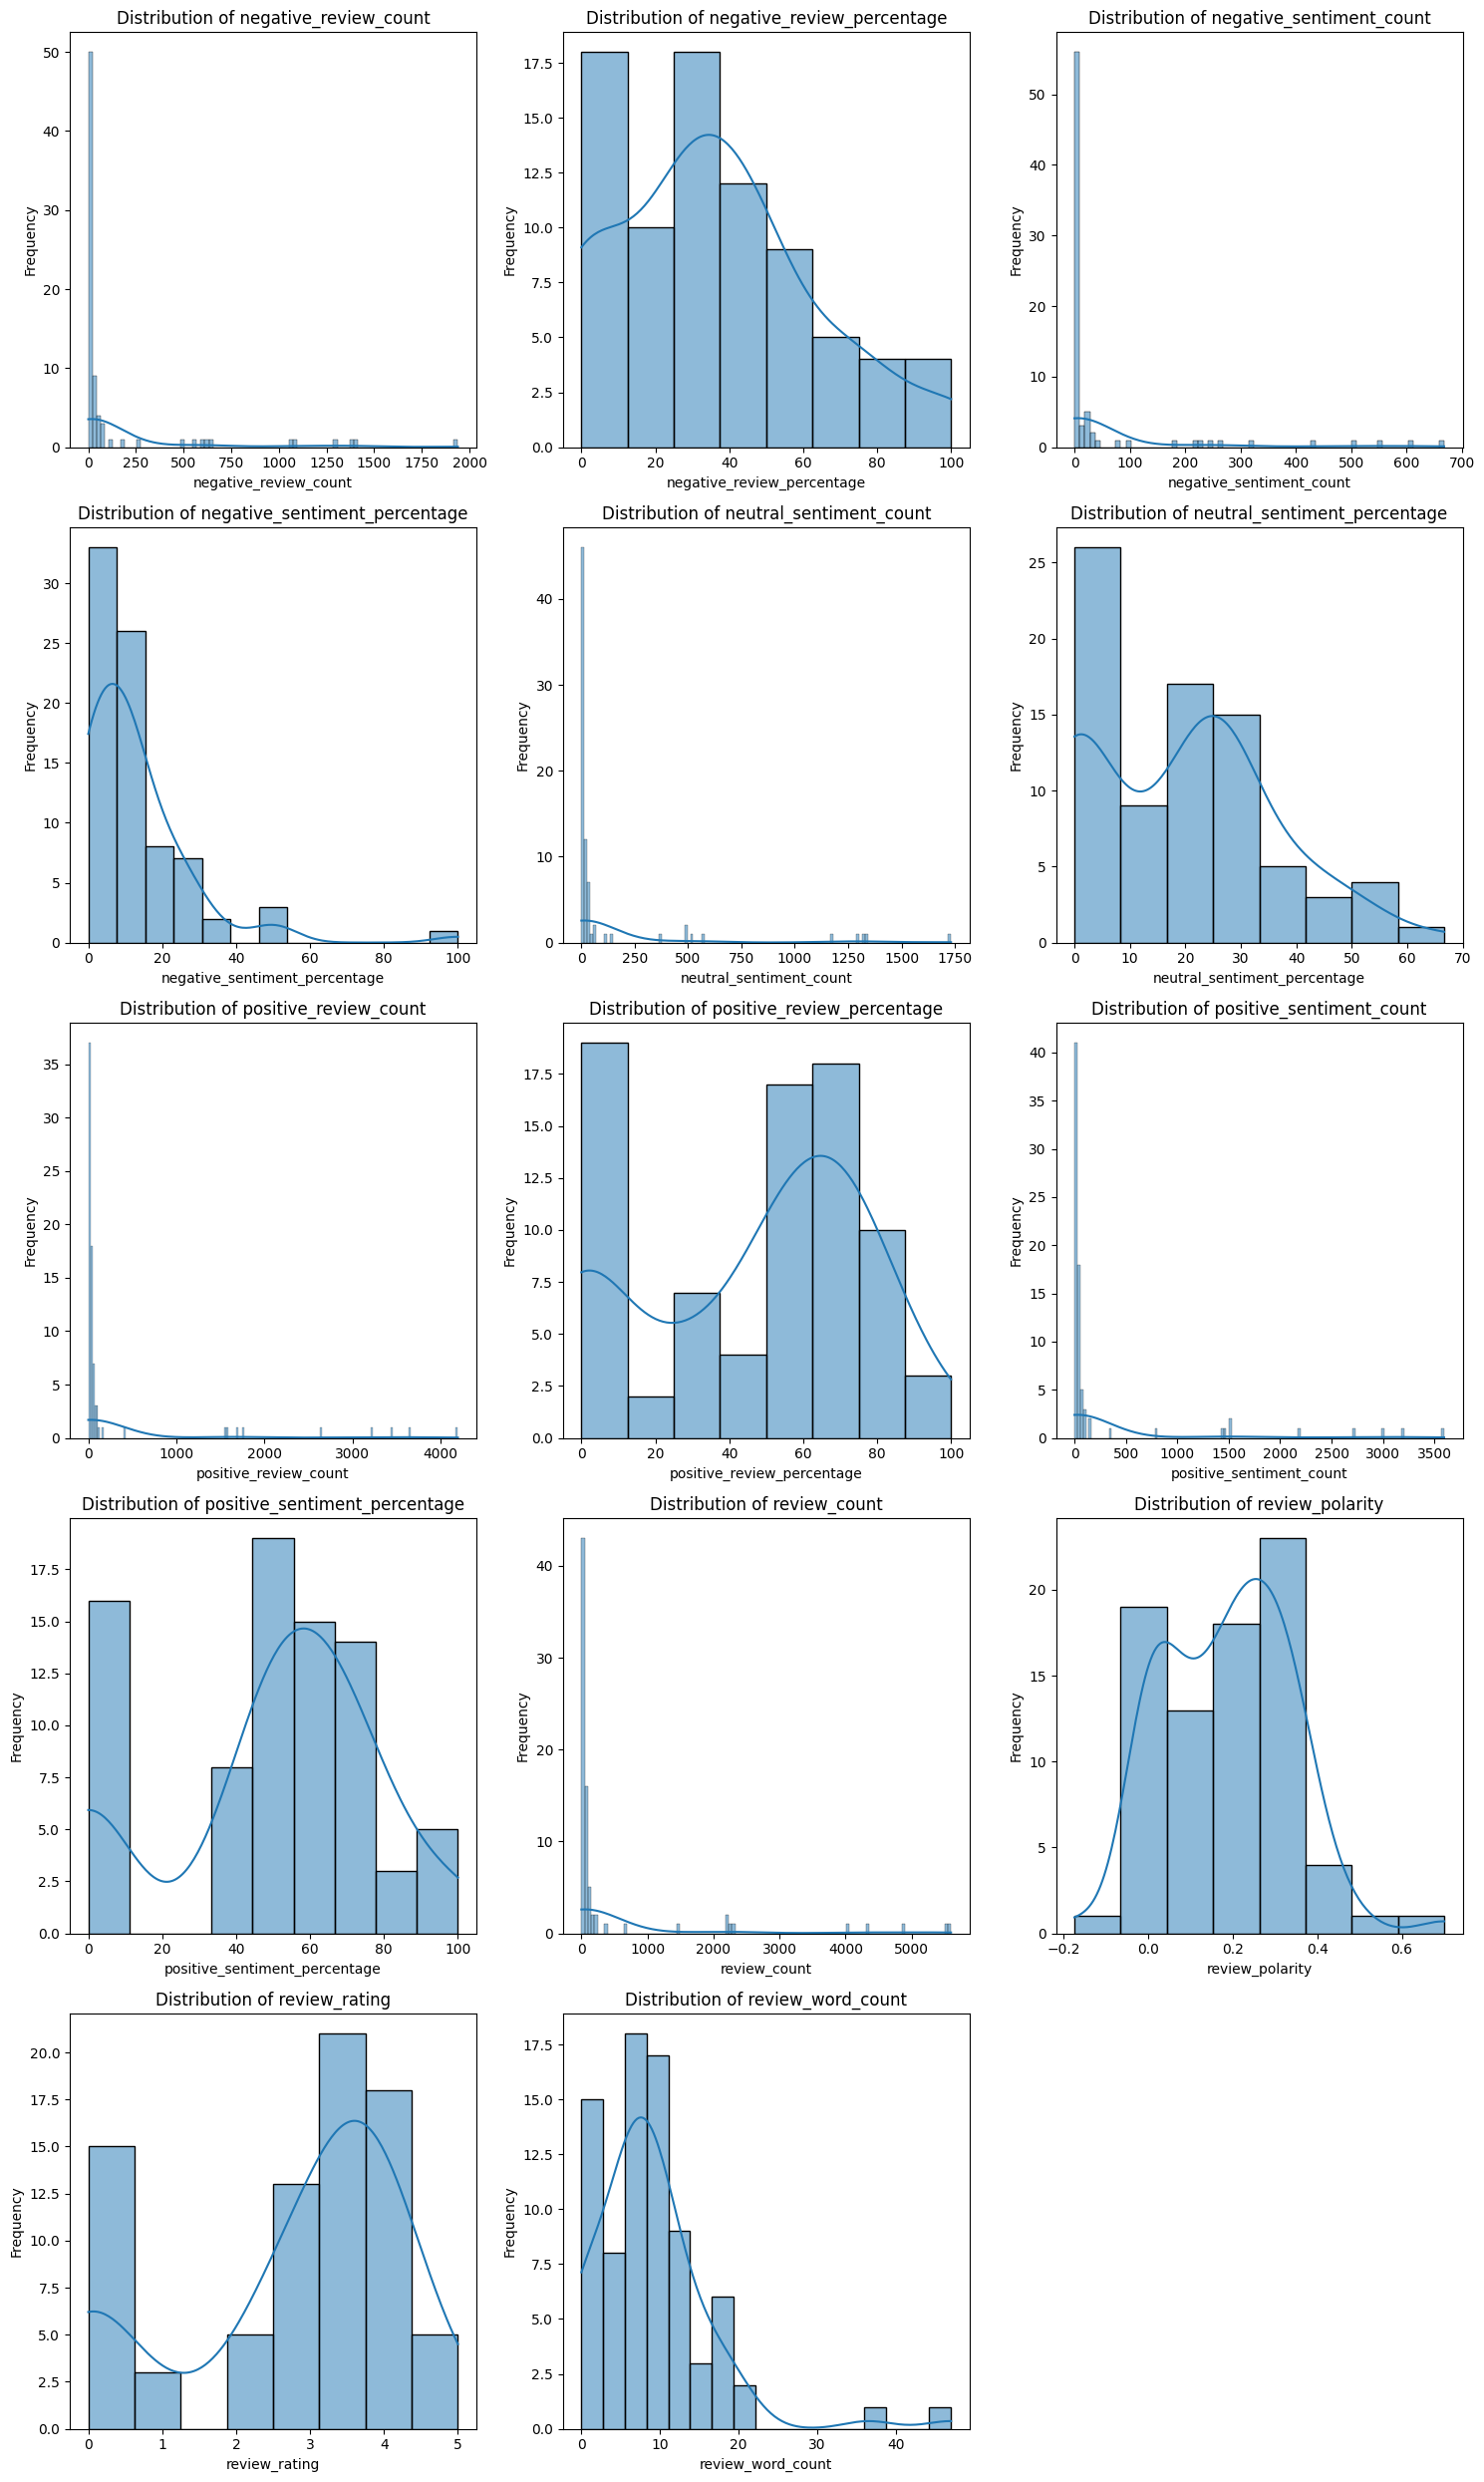

In [553]:
num_features = features_df.shape[1]
num_cols = 3  
num_rows = (num_features + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

axes = axes.flatten()

for idx, column in enumerate(features_df.columns):
    sns.histplot(features_df[column], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')

for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Boxplot of each feature

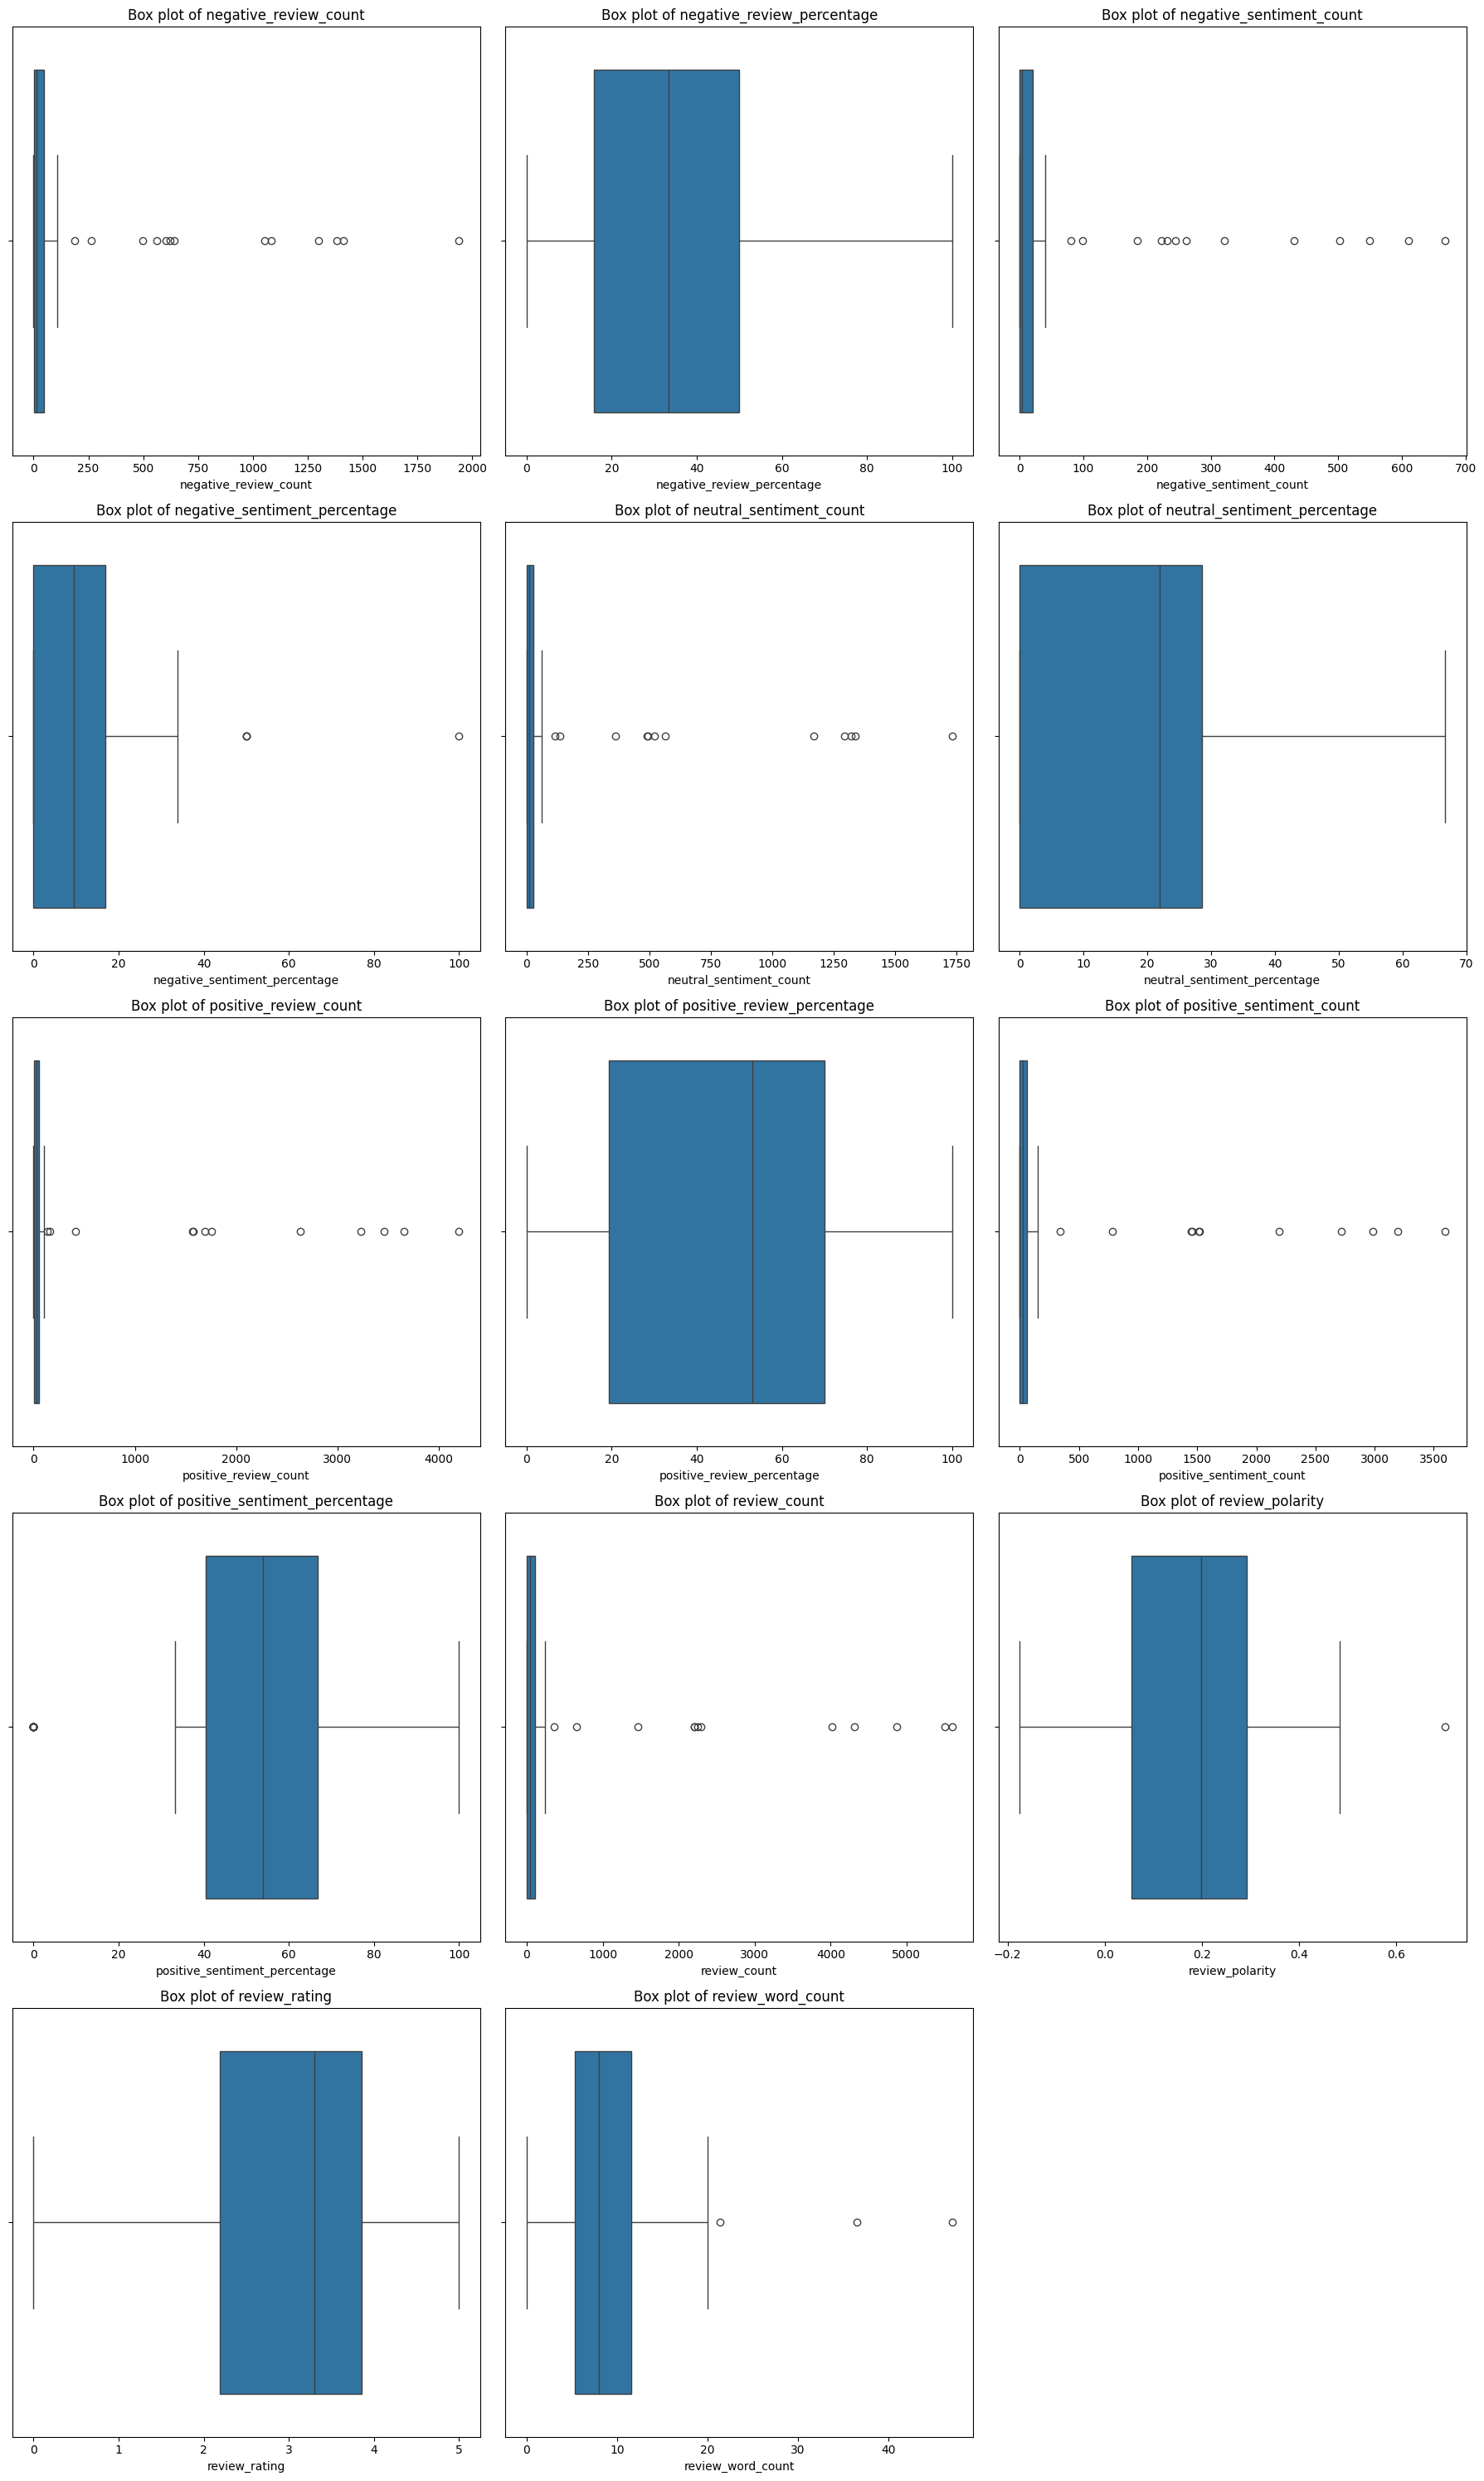

In [554]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 6*num_rows))

for i, column in enumerate(features_df.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.boxplot(x=features_df[column], ax=ax)
    ax.set_title(f'Box plot of {column}')
    ax.set_xlabel(column)

for i in range(num_features, num_rows*num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Pair plot

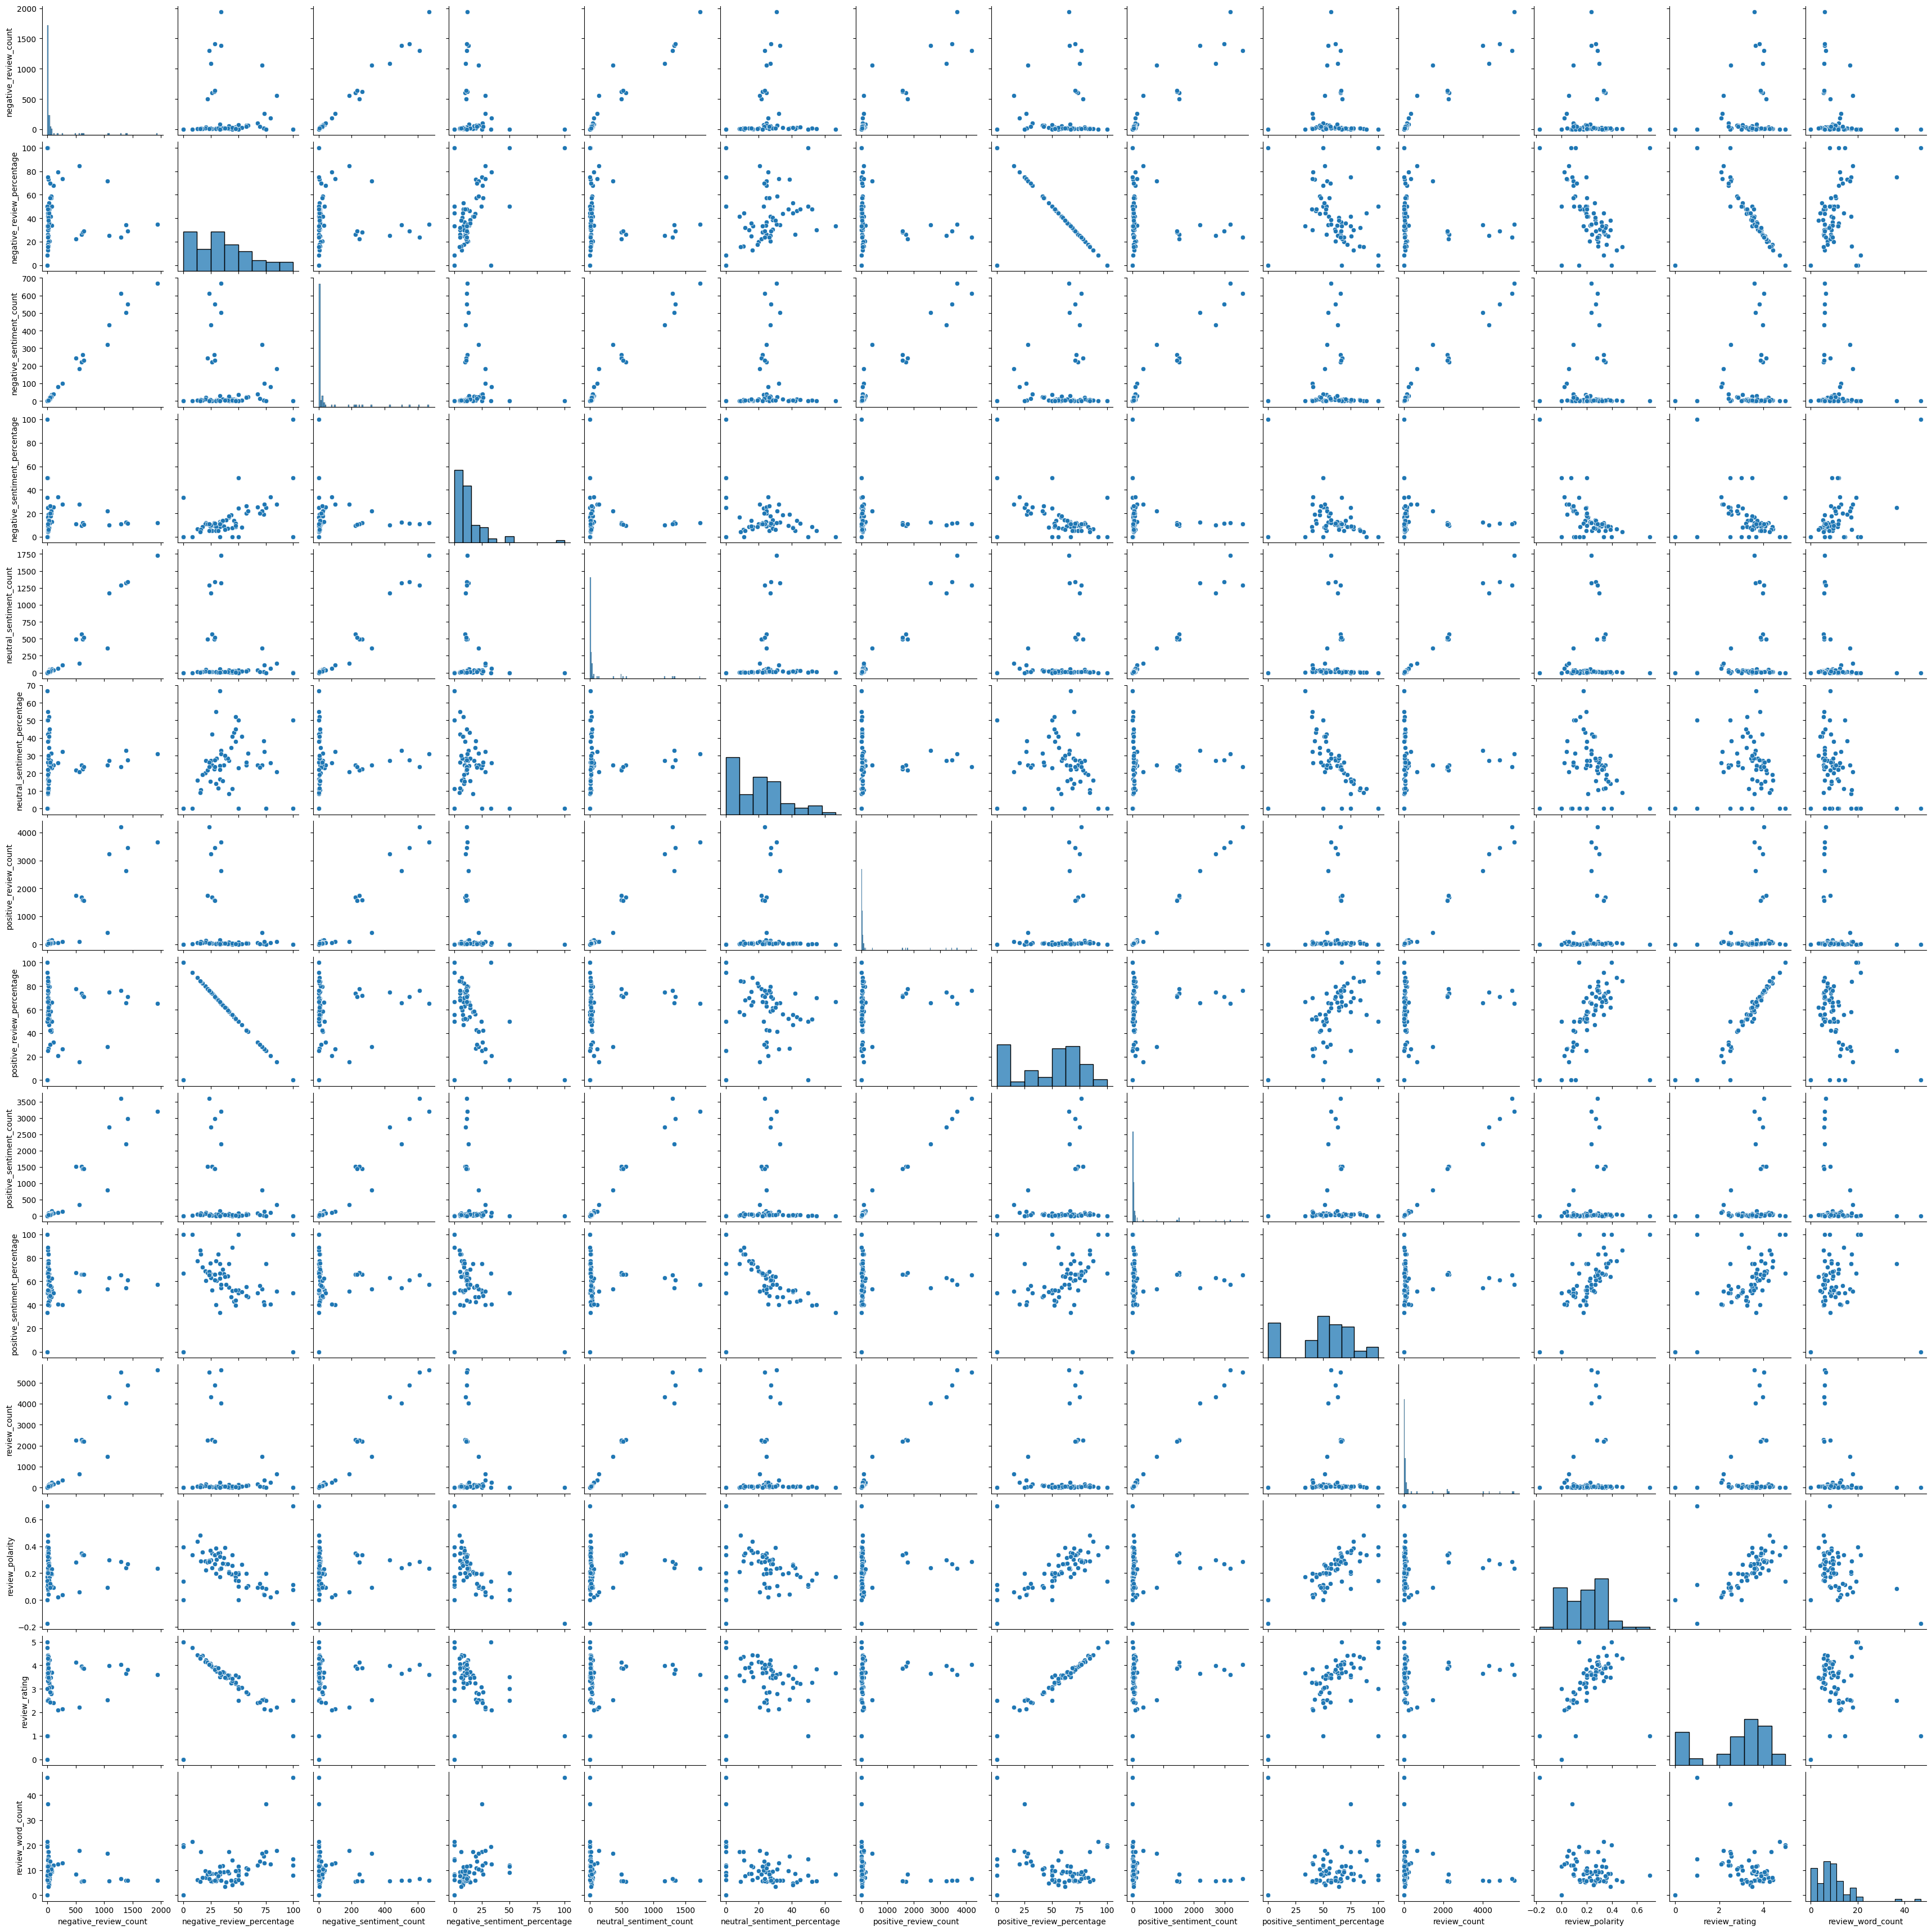

In [555]:
sns.pairplot(features_df)
plt.show()

## Training and Evaluation of Classifiers

In [556]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

param_grid = [
    {
        'classifier': [SVC(kernel='rbf')],
        'preprocessing': [StandardScaler(), MinMaxScaler(), None],
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 'auto', 'scale'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [RandomForestClassifier()],
        'preprocessing': [None],
        'classifier__n_estimators': [50, 100, 150, 200, 250],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    {
        'classifier': [GaussianNB()],
        'preprocessing': [None]
    },
    {
        'classifier': [MLPClassifier(max_iter=3000, random_state=42)],
        'preprocessing': [StandardScaler(), None],
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100,100)],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
        'classifier__learning_rate_init': [0.001, 0.01, 0.1],
        'classifier__activation': ['tanh', 'relu']
    }
]

In [557]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best classifier:\n{}\n".format(grid.best_params_))
print("Best cross-validation F1 score: {:.2f}".format(grid.best_score_))

y_pred = grid.predict(X_test)
test_score = f1_score(y_test, y_pred)
print("Test-set F1 score: {:.2f}".format(test_score))
print("\n Test set Performance report:")
print(classification_report(y_test, y_pred))

Best classifier:
{'classifier': MLPClassifier(max_iter=3000, random_state=42), 'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate_init': 0.01, 'preprocessing': None}

Best cross-validation F1 score: 0.95
Test-set F1 score: 0.91

 Test set Performance report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.83      1.00      0.91        10

    accuracy                           0.87        15
   macro avg       0.92      0.80      0.83        15
weighted avg       0.89      0.87      0.86        15



In [558]:
events = np.sum(y_pred == 1)
non_events = np.sum(y_pred == 0)
print("For test set:")
print(f"Number of predicted events: {events}")
print(f"Number of predicted non-events: {non_events}")

indices = [index for index, value in enumerate(y_pred) if value == 1]

apps = merged_data.loc[X_test.index[indices], 'App_x']
time_windows = merged_data.loc[X_test.index[indices], 'Time window_x']

predicted_events = pd.DataFrame({'App': apps, 'Time window': time_windows})
print("\nInstances of Predicted events:")
print(predicted_events)

For test set:
Number of predicted events: 12
Number of predicted non-events: 3

Instances of Predicted events:
                            App                  Time window
43  com.truthsocial.android.app  Nov 03, 2022 - Nov 09, 2022
26        com.vkontakte.android  Oct 20, 2022 - Oct 26, 2022
41       counter.social.android  Nov 03, 2022 - Nov 09, 2022
67              com.gettr.gettr  Nov 24, 2022 - Nov 30, 2022
58              com.gettr.gettr  Nov 17, 2022 - Nov 23, 2022
28     org.joinmastodon.android  Oct 27, 2022 - Nov 02, 2022
2                      com.mewe  Oct 06, 2022 - Oct 12, 2022
44        com.vkontakte.android  Nov 03, 2022 - Nov 09, 2022
18          com.twitter.android  Oct 20, 2022 - Oct 26, 2022
19     org.joinmastodon.android  Oct 20, 2022 - Oct 26, 2022
31              com.gettr.gettr  Oct 27, 2022 - Nov 02, 2022
37     org.joinmastodon.android  Nov 03, 2022 - Nov 09, 2022


## Inference

In [559]:
feature_files = [os.path.join(base_dir_inference, file) for file in files]

features = pd.DataFrame()
for file in feature_files:
    df = pd.read_csv(file)
    feature_name = file.split("/")[-1].split(".")[0]
    df.columns = ["App"] + list(df.columns[1:]) 
    df = df.melt(id_vars=["App"], var_name="Time window", value_name=feature_name)
    if features.empty:
        features = df
    else:
        features = pd.merge(features, df, on=["App", "Time window"], how="outer")
        
X_new = features.drop(columns=["App", "Time window"])

In [560]:
y_pred = grid.predict(X_new)

events = np.sum(y_pred == 1)
non_events = np.sum(y_pred == 0)
print("Now predicting the next weeks:")
print(f"Number of predicted events: {events}")
print(f"Number of predicted non-events: {non_events}")

indices = [index for index, value in enumerate(y_pred) if value == 1]

apps = features.loc[X_new.index[indices], 'App']
time_windows = features.loc[X_new.index[indices], 'Time window']

predicted_events = pd.DataFrame({'App': apps, 'Time window': time_windows})
print("\nInstances of Predicted events:")
print(predicted_events)

Now predicting the next weeks:
Number of predicted events: 53
Number of predicted non-events: 27

Instances of Predicted events:
                            App                  Time window
0           com.twitter.android  Dec 01, 2022 - Dec 07, 2022
1      org.joinmastodon.android  Dec 01, 2022 - Dec 07, 2022
2                      com.mewe  Dec 01, 2022 - Dec 07, 2022
3   org.hiveinc.TheHive.android  Dec 01, 2022 - Dec 07, 2022
8   com.truthsocial.android.app  Dec 01, 2022 - Dec 07, 2022
9         com.vkontakte.android  Dec 01, 2022 - Dec 07, 2022
11     org.joinmastodon.android  Dec 08, 2022 - Dec 14, 2022
12                     com.mewe  Dec 08, 2022 - Dec 14, 2022
13  org.hiveinc.TheHive.android  Dec 08, 2022 - Dec 14, 2022
15              com.gettr.gettr  Dec 08, 2022 - Dec 14, 2022
16       counter.social.android  Dec 08, 2022 - Dec 14, 2022
18  com.truthsocial.android.app  Dec 08, 2022 - Dec 14, 2022
19        com.vkontakte.android  Dec 08, 2022 - Dec 14, 2022
21     org.joinma

## Visualization of each classifier

In [561]:
def evaluation(model_name, y_test, y_pred):
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    fig, (ax_confusion, ax_roc) = plt.subplots(1, 2, figsize=(12, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_confusion)
    ax_confusion.set_xlabel('Predicted')
    ax_confusion.set_ylabel('Actual')
    ax_confusion.set_title(f"{model_name} Confusion Matrix")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    ax_roc.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f"{model_name} ROC Curve")
    ax_roc.legend()

def plot_learning_curve(estimator, X, y, title, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Test Score')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('F1 Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_feature_importances(model_name, estimator, X_test):
    importances = estimator.named_steps['classifier'].feature_importances_
    feature_names = X_test.columns
    indices = np.argsort(importances)
    feature_names = [feature_names[i] for i in indices]
    importances = importances[indices]
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(range(len(importances)), importances, align='center')
    plt.yticks(range(len(importances)), feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importances for {model_name}")
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

Grid search for SVM:
Best params:
{'classifier__C': 10, 'classifier__gamma': 1, 'preprocessing': MinMaxScaler()}
Best cross-validation score: 0.91
Test-set score: 0.87


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.77      1.00      0.87        10

    accuracy                           0.80        15
   macro avg       0.88      0.70      0.72        15
weighted avg       0.85      0.80      0.77        15



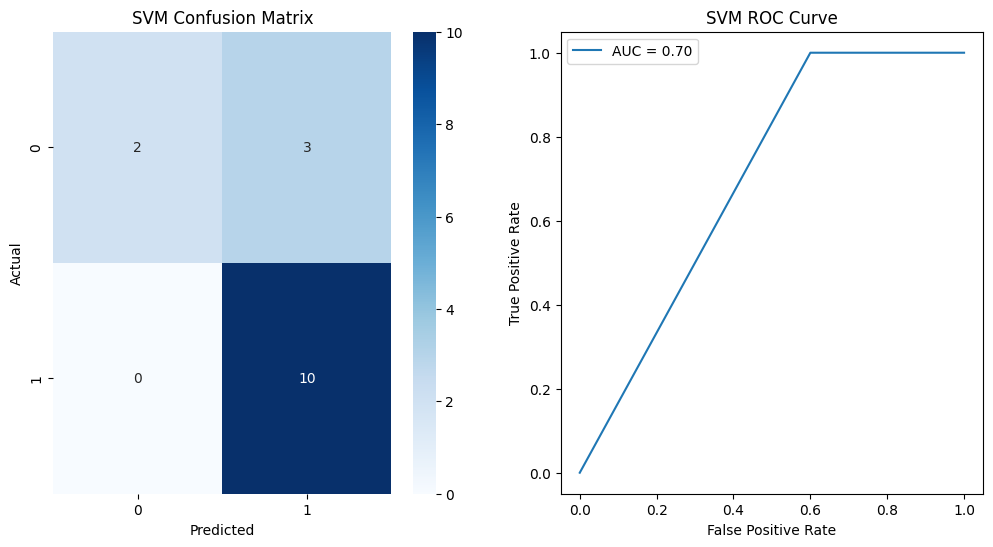

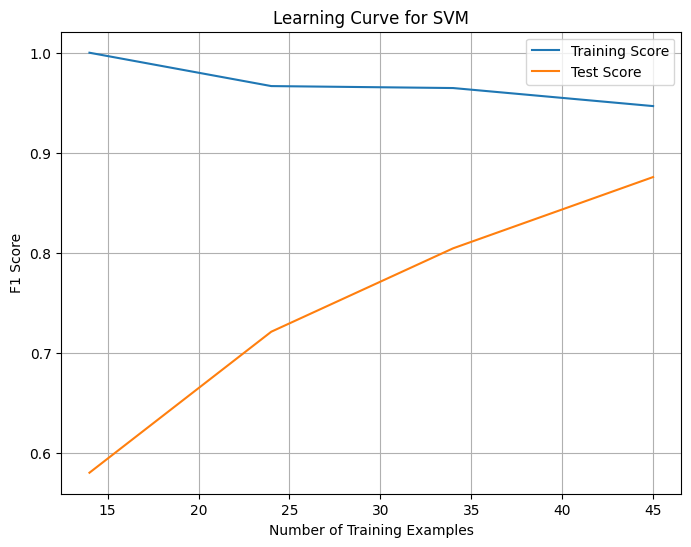


Grid search for Random Forest:
Best params:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'preprocessing': None}
Best cross-validation score: 0.91
Test-set score: 0.95


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.91      1.00      0.95        10

    accuracy                           0.93        15
   macro avg       0.95      0.90      0.92        15
weighted avg       0.94      0.93      0.93        15



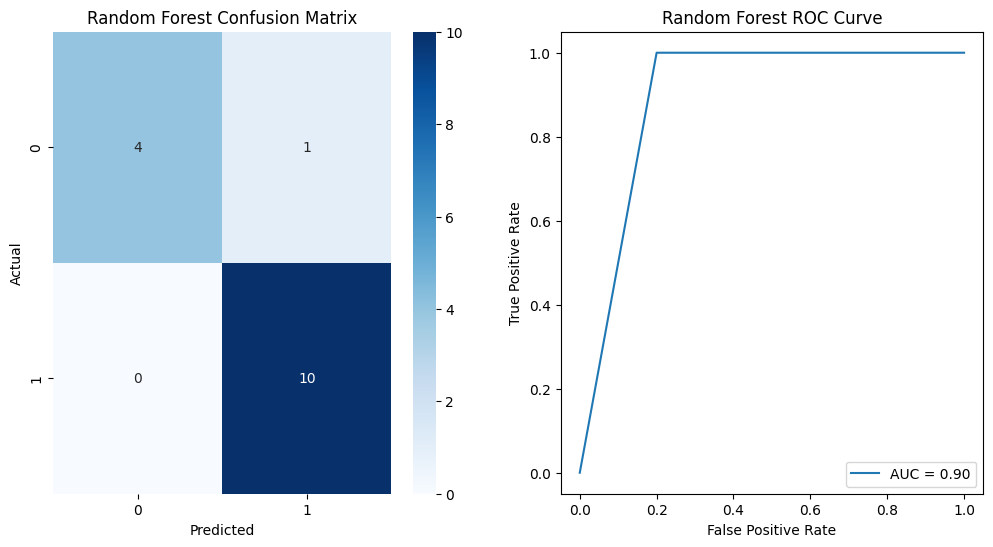

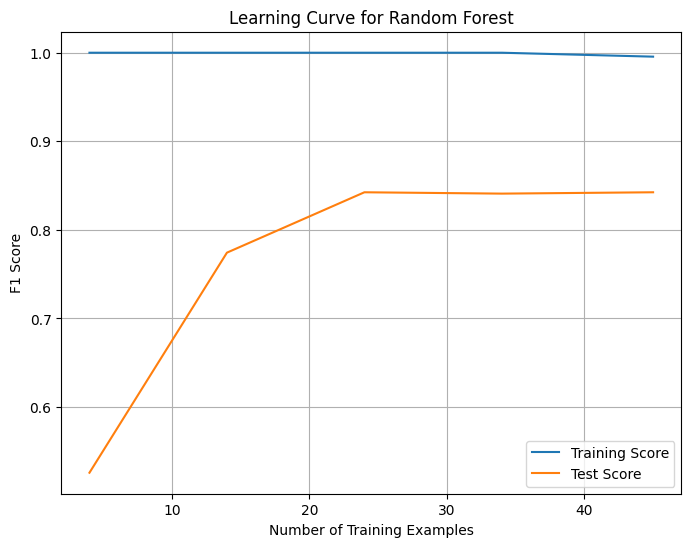

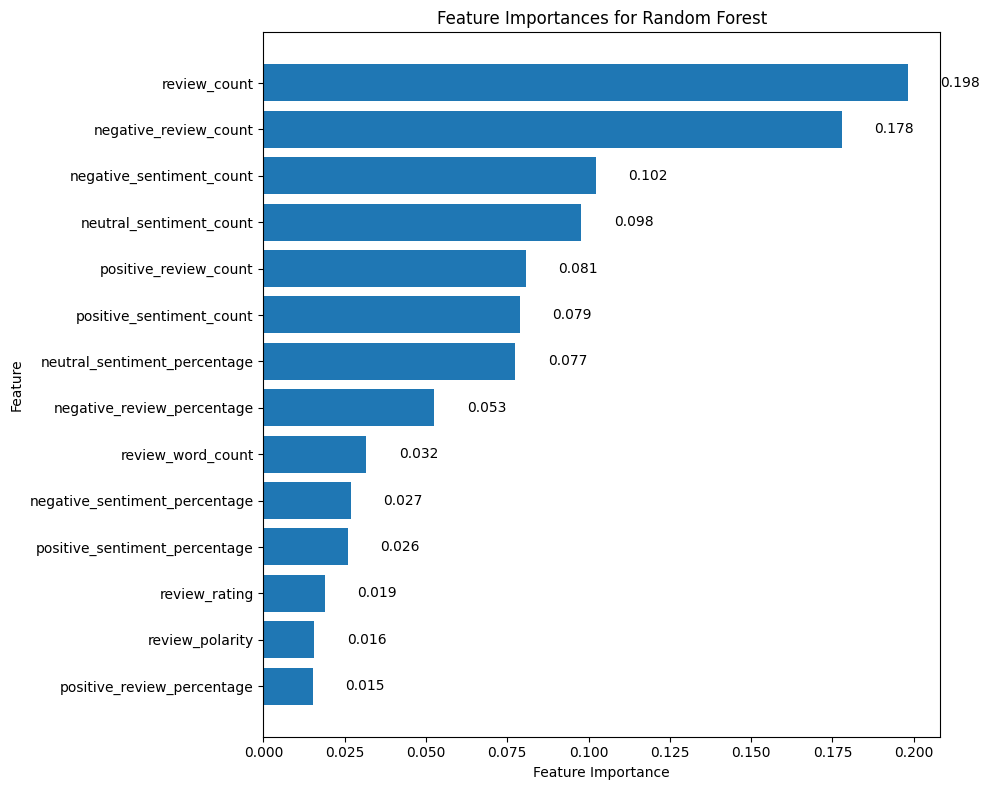


Grid search for Naive Bayes:
Best params:
{'preprocessing': None}
Best cross-validation score: 0.84
Test-set score: 0.83


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.71      1.00      0.83        10

    accuracy                           0.73        15
   macro avg       0.86      0.60      0.58        15
weighted avg       0.81      0.73      0.67        15



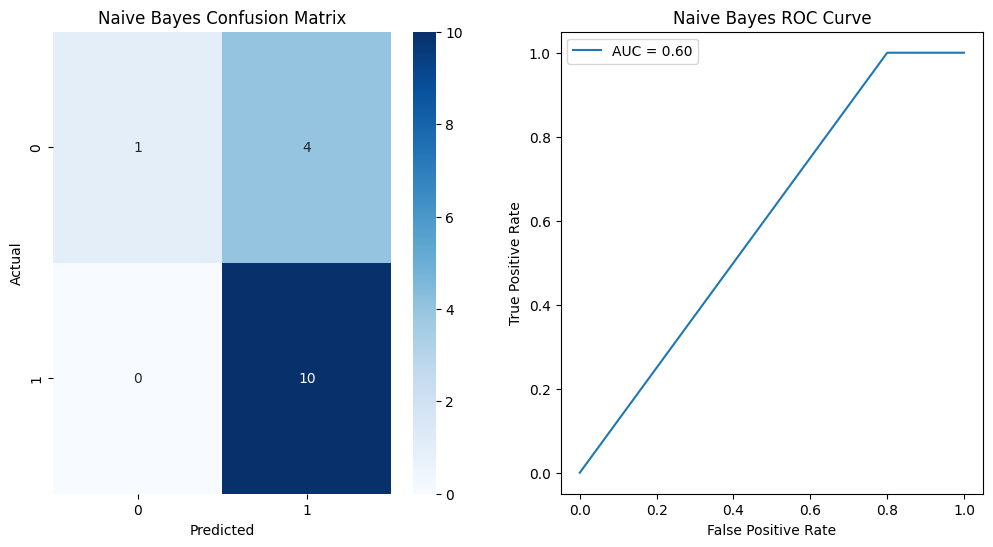

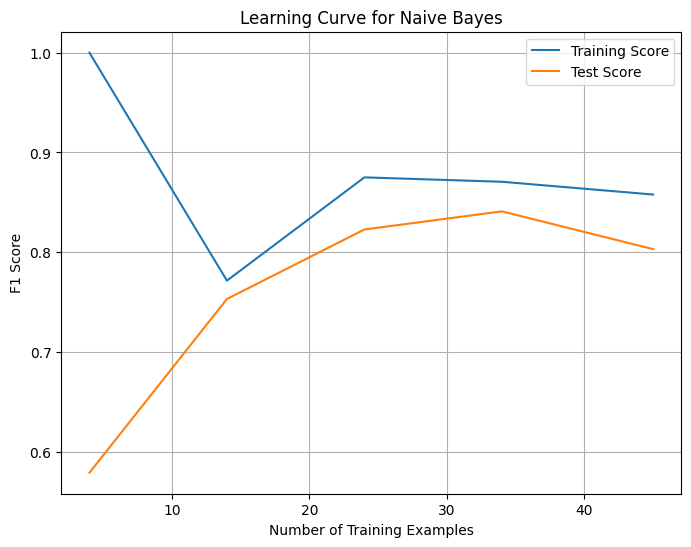


Grid search for MLP:
Best params:
{'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate_init': 0.01, 'preprocessing': None}
Best cross-validation score: 0.95
Test-set score: 0.91


MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.83      1.00      0.91        10

    accuracy                           0.87        15
   macro avg       0.92      0.80      0.83        15
weighted avg       0.89      0.87      0.86        15



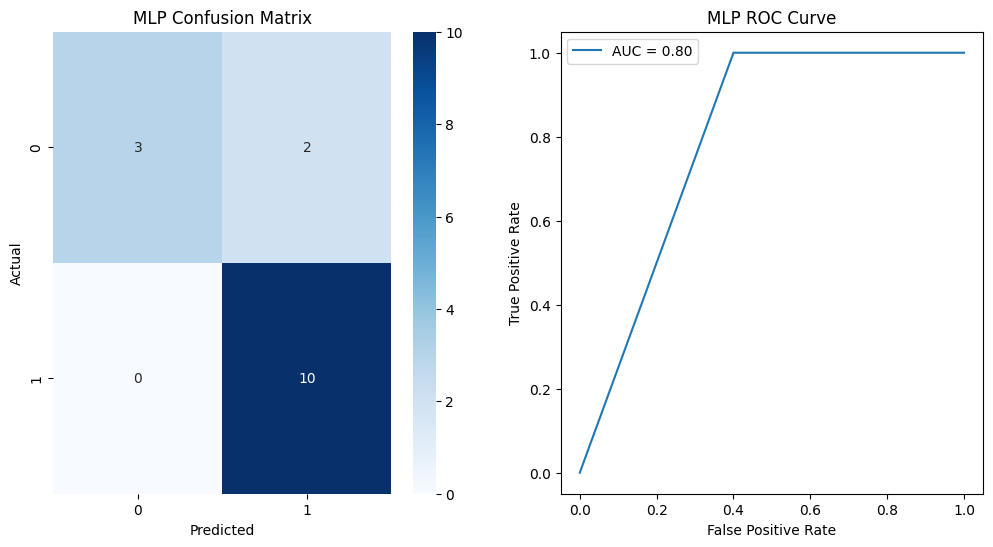

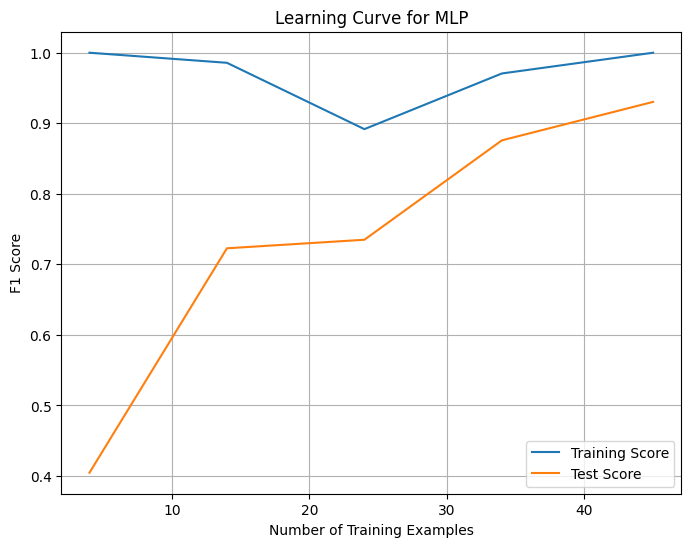

In [562]:
models = [
    {
        'name': 'SVM',
        'classifier': SVC(kernel='rbf'),
        'param_grid': {
            'preprocessing': [StandardScaler(), MinMaxScaler(), None],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 'auto', 'scale'],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    {
        'name': 'Random Forest',
        'classifier': RandomForestClassifier(),
        'param_grid': {
            'preprocessing': [None],
            'classifier__n_estimators': [50, 100, 150, 200, 250],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    {
        'name': 'Naive Bayes',
        'classifier': GaussianNB(),
        'param_grid': {
            'preprocessing': [None]
        }
    },
    {
        'name': 'MLP',
        'classifier': MLPClassifier(max_iter=3000, random_state=42),
        'param_grid': {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100,100)],
            'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
            'classifier__activation': ['tanh', 'relu']
        }
    }
]

for model in models:
    print(f"Grid search for {model['name']}:")
    
    pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', model['classifier'])])
    
    grid_search = GridSearchCV(pipe, model['param_grid'], cv=5, scoring='f1')
    
    grid_search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    y_pred = grid_search.predict(X_test)
    test_score = f1_score(y_test, y_pred)
    print("Test-set score: {:.2f}".format(test_score))
    print()

    evaluation(model['name'], y_test, y_pred)
    plot_learning_curve(grid_search.best_estimator_, X_train, y_train, title=f"Learning Curve for {model['name']}")

    #feature importances for Random Forest
    if model['name'] == 'Random Forest':
        plot_feature_importances(model['name'], grid_search.best_estimator_, X_test)
    
    print()